In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import uniform, norm, laplace, beta
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import warnings 
import pystan
import arviz
warnings.filterwarnings('ignore')

# Introduction to Bayesian Modeling (Part 2b)

In this session, we will go through a bunch of useful models and get familiar with running multiple chains, thinning and burn in implementation in *stan*.

## Linear regression

Let us assume that we have a bunch of data $y_i \in \mathbb{R}$ possibly determined by some scalar or vector features $x_i$. For instance, we will use the following data set, where $y_i$ is the distance of a moving object in meters measured by a noisy instrument, and the only feature that we have is the time measured in seconds:

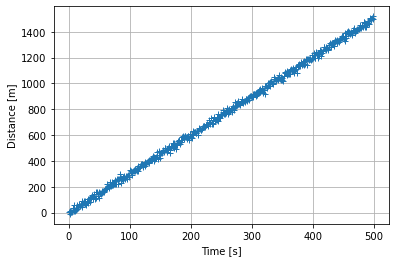

In [2]:
data = np.load('distance.npz')
y = data['y']
x = data['x']

plt.plot(x, y, '+')
plt.xlabel('Time [s]')
plt.ylabel('Distance [m]')
plt.show()

We see that there is clearly a linear trend, and a straight line model could explain the data evolution. Such a model would have the form

$$
y_i = \beta_0 + \beta_1 x_i + \varepsilon_{i}, \qquad i=1,\ldots,N,
$$

where:
- $y_i$ is the **known** modeled variable (regresand), here the distance
- $\beta_0, \beta_1$ are the **unknown** regression coefficients (aka weights) - the intercept and the slope,
- $x_i$ is the **known** regressor (aka feature), here the time,
- $\varepsilon_i$ is the **unknown** noise corrupting the determinism. Usually we assume it follows the normal (Gaussian) distribution.

In the vector form

$$
y_i = X_i^\intercal \beta + \varepsilon_i, \qquad \varepsilon_i \sim \mathcal{N}(0,\sigma^2),
$$

kde $\beta=[\beta_0, \beta_1]^\intercal$ and $X_i=[1, x_i]^\intercal$.

**The goal is to fit the line, i.e., to estimate $\beta$ and $\sigma^2$. The estimates would** (in some sense) lead to **optimal interpolation of the data.**

Coherently with the Bayesian principles, we need to define:
- the model for $y_i$,
- the prior for the vector $\beta$ (*two-dimensional!!!*)
- the prior for the noise variance $\sigma^2$ or its square root.

One possible setting is this one:

$$
\begin{aligned}
y_i &\sim \mathcal{N}(x_i^\intercal \beta, \sigma^2),\\
\beta &\sim \mathcal{N}(m, S),\\
\sigma &\sim \mathcal{G}(a, b). \\
\end{aligned}
$$

Then, we only choose some suitable values of hyperparameters $m, S, a$ and $b$, e.g., so that the priors are vague enough.

In [3]:
data_code = """
data {
    int<lower=0> N;       // number of observations
    int<lower=0> K;       // number of regressors
    matrix[N, K] X;       // design matrix
    vector[N] y;          // observations vector
    
    // ------- If we want to set hyperparameters externally, we add the following lines --------- 
    vector[K] m;          // hyperparameter for normal prior
    cov_matrix[K] S;      // hyperparameter for normal prior
    real<lower=0> a;      // hyperparameter for gamma prior
    real<lower=0> b;      // hyperparameter for gamma prior
}

parameters {
    vector[K] beta;       // coefficients for predictors
    real<lower=0> sigma;  // noise st. dev.
}

model {
    beta ~ multi_normal(m, S);          // prior for beta
    sigma ~ gamma(a, b);                // prior for sigma
    y ~ normal(X * beta, sigma);        // model pdf
}
"""

sm = pystan.StanModel(model_code=data_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2495d23a95cdc8140a986582801b7cd0 NOW.


Next, we prepare the data block. Note, that $X$ is a matrix containing $X_i = [1, x_1]$ as rows. Additionally, we need to specify the prior hyperparameters that we haven't specified in the `data_code` block.

In [4]:
X = np.c_[np.ones((y.size,1)), x]

data = {
    'X': X,
    'N': X.shape[0],
    'K': X.shape[1],
    'y': y,
    'm': np.zeros(X.shape[1]),
    'S': np.eye(X.shape[1]) * 10,
    'a': 0.001,
    'b': 0.001
}

Let's fit! :D

This time, we will use multiple chains, thinning and burn-in (aka warmup).

In [12]:
fit = sm.sampling(data=data, iter=20000, warmup=1000, thin=2, chains=2, verbose=True)
print(fit)

Inference for Stan model: anon_model_2495d23a95cdc8140a986582801b7cd0.
2 chains, each with iter=20000; warmup=1000; thin=2; 
post-warmup draws per chain=9500, total post-warmup draws=19000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   1.48    0.01   1.21  -0.88   0.66   1.48   2.31   3.87  13780    1.0
beta[2]   3.01  3.5e-5 4.3e-3    3.0   3.01   3.01   3.01   3.02  14673    1.0
sigma    14.82  3.7e-3   0.47  13.92   14.5  14.81  15.13  15.77  16565    1.0
lp__     -1598    0.01   1.23  -1601  -1598  -1597  -1597  -1596  12411    1.0

Samples were drawn using NUTS at Tue Jul 14 15:24:01 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Naturally, we want to see the **trace plots** and the estimated **posterior densities**...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff23f7f6880>,
      dtype=object)

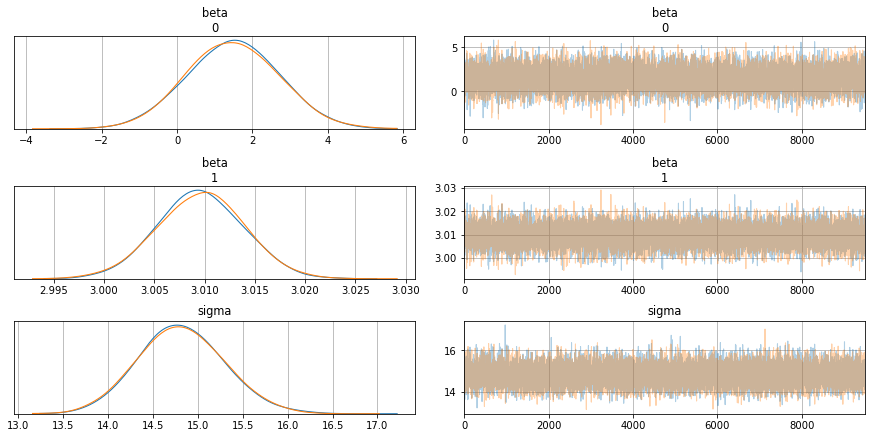

In [13]:
inferencedata = arviz.from_pystan(posterior=fit)
arviz.plot_trace(inferencedata)

Well, ready for interpolation? We exploit the posterior means as the point estimates of $\beta_0$ (intercept) and $\beta_1$ (slope), and fit the straight line.

In [14]:
posterior_means = fit.get_posterior_mean()
print(posterior_means)

[[ 1.49276837e+00  1.47471559e+00]
 [ 3.00958948e+00  3.00966006e+00]
 [ 1.48225814e+01  1.48155302e+01]
 [-1.59829372e+03 -1.59832194e+03]]


Hm, but we don't want multiple estimates of the same quantities. Let's average them!

In [15]:
posterior_means_avg = posterior_means.mean(axis=1)
print(posterior_means_avg)

[ 1.48374198e+00  3.00962477e+00  1.48190558e+01 -1.59830783e+03]


We need only the first two numbers, the intercept & slope:

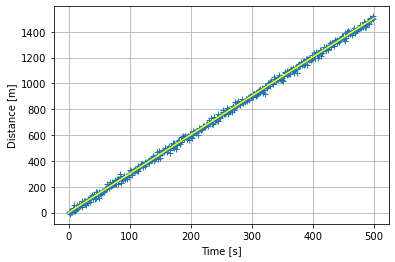

In [16]:
point_preds = X.dot(posterior_means_avg[:2])

plt.plot(x, y, '+')
plt.xlabel('Time [s]')
plt.ylabel('Distance [m]')
plt.plot(x, point_preds, color='yellow')
plt.show()

Strictly speaking, we could/should be interested in the [posterior predictive distributions](https://en.wikipedia.org/wiki/Posterior_predictive_distribution), rather than the point predictions. These distributions say, where could we expect the predictions to lie with which uncertainty. However, this is slighlty more complicated, as these distributions involve both the model uncertainty (due to the noise $\sigma^2$) and the uncertainties about the estimated variables ($\beta_0, \beta_1, \sigma^2$).

Let's look at the point forecasts...

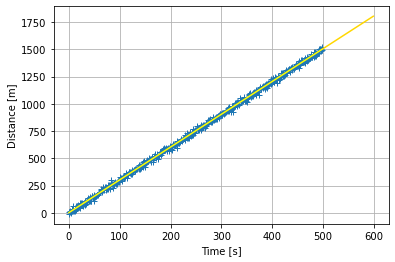

In [20]:
x_future = np.arange(500, 600)
X_future = np.c_[np.ones(x_future.size), x_future]
point_preds_future = X_future.dot(posterior_means_avg[:2])

plt.plot(x, y, '+')
plt.xlabel('Time [s]')
plt.ylabel('Distance [m]')
plt.plot(x, point_preds, color='yellow')
plt.plot(x_future, point_preds_future, color='gold')
plt.show()

## Logistic regression

While the linear regression assumes that $y_i \in \mathbb{R}$, the logistic regression serves for modeling **binary random variable**

$$
y_i = 
\begin{cases} 
1 \quad \text{with probability $p_i$}, \\ 
0 \quad \text{with probability $1 - p_i$}.\
\end{cases}
$$

However, the regressor $x_i$ may be multivariate and real, thus we need a proper transform of $x_i^\intercal \beta$ to $[0,1]$. For this purpose, we employ the inverse of the **logit** function, which is the **logistic function** providing

$$
\mathbb{E}[y_i] = p_i = \mathrm{logit}^{-1}(x_i^\intercal \beta),
$$

![logit](logit_expit.png)

We already know that a suitable distribution for $y_i$ is the **Bernoulli distribution** parameterized by $p_i$,

$$
y_i \sim \textit{Bernoulli}(p_i)
$$

and with the **mean value** $\mathbb{E}[y_i] = p_i$. Hence this means

$$\textit{Bernoulli}(\mathrm{logit}^{-1}(x_i^\intercal \beta)),$$

which is the `bernoulli_logit` model in `Stan`.

### Skin - NonSkin classification

The example considers the Skin-NonSkin dataset of Bhatt and Dhall. It consists of 245,057 samples of which 50,859 are skin samples and 194,198 are non-skin samples. The dataset was collected by randomly sampling RGB values from face images of various age groups (young, middle, and old), race groups (white, black, and Asian), and gender. The samples were obtained from the FERET and PAL databases. Each data item consisted of four variables -- B, G, R and the class label.

Our goal is to estimate the logistic model parameters where the regression vectors were $x_{i} = [1, B_{i}, G_{i}, R_{i}]^{\intercal}$.

Three randomly chosen rows:

    ---
    B, G, R, Class
    242, 169, 161,   2
    218, 211, 202,   2
    110, 150, 209,   1
    ---

Let's load data:

In [39]:
data = np.loadtxt('skin-nonskin.csv', delimiter=',')
data

array([[242., 169., 161.,   1.],
       [218., 211., 202.,   1.],
       [110., 150., 209.,   0.],
       ...,
       [255., 128.,   0.,   1.],
       [173., 187., 216.,   1.],
       [167., 163., 114.,   1.]])

As in the linear regression, we want regressors in the form $[1, x_i]$ where $x_i$ are the values of [B_i, G_i, R_i]. However, it is possible to enforce the offset term in Stan separately, hence we skip those 1s:

In [40]:
X = data[:,:3]
X

array([[242., 169., 161.],
       [218., 211., 202.],
       [110., 150., 209.],
       ...,
       [255., 128.,   0.],
       [173., 187., 216.],
       [167., 163., 114.]])

Next, we create the vector of observations $y$:

In [41]:
y = data[:,-1]

The `Stan` model may look like this:

In [45]:
logreg2_model = """
data {
  int<lower=0> N;               // number of observations
  int<lower=0> K;               // number of regressors excluding offset
  int<lower=0,upper=1> y[N];    // observations
  row_vector[K] X[N];           // regressors (excluding offset)
}

parameters {
  real beta_offset;             // beta for offset
  vector[K] beta;               // beta for B,G,R regressors
}

model {
  beta_offset ~ normal(0, 10);  // prior for offset beta. The rest is uniform ;)

  for(n in 1:N) {
    y[n] ~ bernoulli_logit(beta_offset + X[n]*beta);
  }
}
"""
sm = pystan.StanModel(model_code=logreg2_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e23e66a3e9bc21c47033bdbe7bc7bd5 NOW.


Time to generate the chains :)

In [46]:
data = {
    'y': y.astype('int'),
    'N': y.size,
    'K': 3,
    'X': X
}
print(data)
fit = sm.sampling(data=data, iter=5000, warmup=1000, thin=2, 
                  chains=3, verbose=True)

{'y': array([1, 1, 0, ..., 1, 1, 1]), 'N': 5000, 'K': 3, 'X': array([[242., 169., 161.],
       [218., 211., 202.],
       [110., 150., 209.],
       ...,
       [255., 128.,   0.],
       [173., 187., 216.],
       [167., 163., 114.]])}


In [47]:
print(fit)

Inference for Stan model: anon_model_9e23e66a3e9bc21c47033bdbe7bc7bd5.
3 chains, each with iter=5000; warmup=1000; thin=2; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

               mean se_mean     sd   2.5%     25%     50%     75%   97.5%  n_eff   Rhat
beta_offset    4.28  3.3e-3   0.19   3.92    4.15    4.28    4.41    4.64   3208    1.0
beta[1]        0.03  3.1e-5 1.9e-3   0.02    0.02    0.03    0.03    0.03   3841    1.0
beta[2]     -5.6e-3  3.9e-5 2.3e-3  -0.01 -7.2e-3 -5.6e-3 -4.1e-3 -1.1e-3   3517    1.0
beta[3]       -0.03  1.7e-5 1.1e-3  -0.04   -0.04   -0.03   -0.03   -0.03   4291    1.0
lp__          -1262    0.02   1.42  -1265   -1262   -1261   -1261   -1260   3456    1.0

Samples were drawn using NUTS at Sun Jul 19 18:29:51 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff248445eb0>,
      dtype=object)

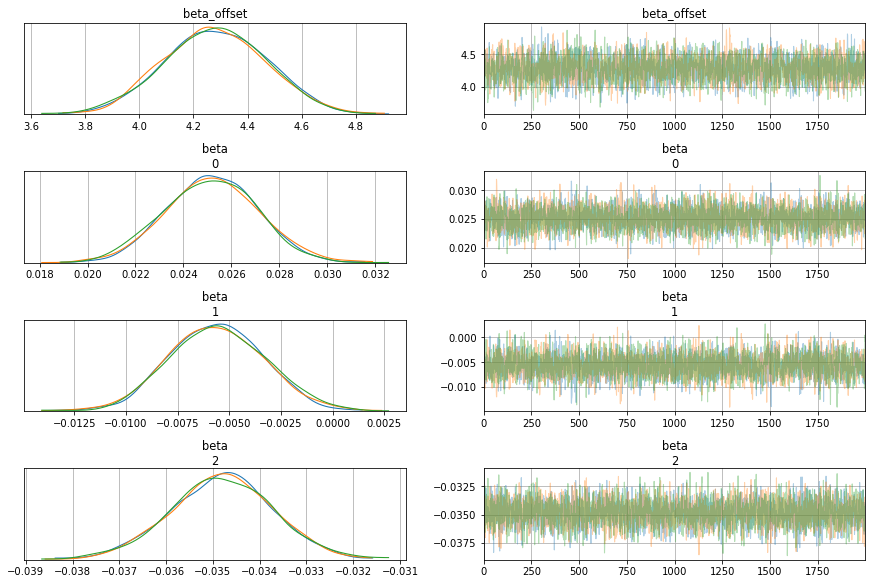

In [48]:
inferencedata = arviz.from_pystan(posterior=fit)
arviz.plot_trace(inferencedata)

Let's compare to MLE estimates provided by `sklearn`:

In [50]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',fit_intercept=True,
                         multi_class='auto').fit(X, y)
print(f'MLE:\n {np.array2string(np.c_[clf.intercept_, clf.coef_].flatten(), precision=5)}')
print(f'STAN:\n {np.array2string(fit.get_posterior_mean()[:-1].T, precision=5)}')

MLE:
 [ 4.26723  0.02513 -0.00562 -0.03476]
STAN:
 [[ 4.28368  0.02518 -0.00568 -0.03483]
 [ 4.27755  0.0252  -0.00569 -0.03482]
 [ 4.27667  0.02506 -0.00554 -0.03482]]


What is important is that the Bayesian approach yields the posterior distributions quantifying our knowledge about the estimates. Not just numbers.

# Final remarks

- It's always necessary to specify the model correctly.
- If you don't specify priors, (improper) uniform priors are used.
- There are other blocks available in the `stan` model:
    - `generated_quantities` that allow to generate extra quantiaties like posterior predictives,
    - `transformed_data` and `transformed_parameters` that are useful for many tricks for better/stable computations.
- Go throught the `stan` manual: https://mc-stan.org/docs/2_23/stan-users-guide/index.html#overview